In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.data import EdgeSplitter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import numpy as np
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

2023-03-24 10:41:25.399925: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 10:41:25.559850: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-24 10:41:25.564453: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-24 10:41:25.564474: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
train_df = pd.read_csv('../../../lm-vol/PicoDomain/PICO_train.csv')

In [3]:
test_df = pd.read_csv('../../../lm-vol/PicoDomain/PICO_test.csv')

In [4]:
train_df = train_df.assign(client = train_df['client'].str.split('/').map(lambda x: x[0]))
train_df.client = train_df.client.str.upper()
train_df.service = train_df.service.str.upper()
train_df

,client,service,id.orig_h,ts
0,HR-WIN7-2$,KRBTGT/G.LAB,10.99.99.30,2019-07-19 00:05:03.935567+00:00
1,HR-WIN7-2$,KRBTGT/G.LAB,10.99.99.30,2019-07-19 00:05:03.936682+00:00
2,SUPERSECRETXP$,KRBTGT/G.LAB,10.99.99.160,2019-07-19 00:08:55.924635+00:00
3,BDUCK,KRBTGT/G.LAB,10.99.99.30,2019-07-19 00:13:13.299460+00:00
4,BDUCK,KRBTGT/G.LAB,10.99.99.30,2019-07-19 00:13:13.300481+00:00
...,...,...,...,...
256,RND-WIN10-1$,DNS/CORP-DC.G.LAB,10.99.99.29,2019-07-19 18:06:19.736786+00:00
257,JSNAKE,KRBTGT/G.LAB,10.99.99.29,2019-07-19 18:07:59.456464+00:00
258,JSNAKE,KRBTGT/G.LAB,10.99.99.29,2019-07-19 18:07:59.457692+00:00
259,JSNAKE,CIFS/CORP-DC,10.99.99.29,2019-07-19 18:07:59.458937+00:00


In [5]:
test_df = test_df.assign(client = test_df['client'].str.split('/').map(lambda x: x[0]))
test_df.client = test_df.client.str.upper()
test_df.service = test_df.service.str.upper()
test_df

,client,service,id.orig_h,ts,malicious
0,RMOLE,LDAP/CORP-DC.G.LAB/G.LAB,10.99.99.27,2019-07-19 18:08:02.481818+00:00,0
1,RMOLE,CIFS/CORP-DC.G.LAB/G.LAB,10.99.99.27,2019-07-19 18:08:03.242606+00:00,0
2,RMOLE,LDAP/CORP-DC.G.LAB,10.99.99.27,2019-07-19 18:08:03.318908+00:00,0
3,RND-WIN10-2$,KRBTGT/G.LAB,10.99.99.27,2019-07-19 18:08:03.457718+00:00,0
4,RND-WIN10-2$,KRBTGT/G.LAB,10.99.99.27,2019-07-19 18:08:03.459095+00:00,0
...,...,...,...,...,...
831,ADMINISTRATOR,RPCSS/CORP-DC.G.LAB,10.99.99.27,2019-07-21 15:57:53.695307+00:00,1
832,ADMINISTRATOR,KRBTGT/G.LAB,10.99.99.27,2019-07-21 15:57:53.704911+00:00,1
833,ADMINISTRATOR,HOST/CORP-DC.G.LAB,10.99.99.27,2019-07-21 15:57:53.713454+00:00,1
834,ADMINISTRATOR,RESTRICTEDKRBHOST/CORP-DC,10.99.99.27,2019-07-21 15:57:53.715331+00:00,1


In [6]:
train_clients = list(train_df.client)
train_ips = list(train_df['id.orig_h'])
train_service = list(train_df.service)
train_nodes = set(train_clients + train_ips + train_service)
# print(len(train_nodes))
test_clients = list(test_df.client)
test_ips = list(test_df['id.orig_h'])
test_service = list(test_df.service)
test_nodes = set(test_clients + test_ips + test_service)
print(len(test_nodes))
print(test_nodes.difference(train_nodes))
print(len(test_nodes.difference(train_nodes)))

47
{'HOST/CORP-DC.G.LAB', 'RPCSS/RND-WIN10-1.G.LAB', 'RPCSS/HR-WIN7-2', 'ADMINISTRATOR', 'RPCSS/RND-WIN10-2.G.LAB', 'RPCSS/CORP-DC.G.LAB', 'RESTRICTEDKRBHOST/HR-WIN7-1', 'LOCAL.ADMIN', 'RESTRICTEDKRBHOST/RND-WIN10-2', 'RPCSS/RND-WIN10-2', 'RPCSS/RND-WIN10-1', 'HOST/SUPERSECRETXP.G.LAB', 'RESTRICTEDKRBHOST/RND-WIN10-1', 'RPCSS/HR-WIN7-1.G.LAB', 'PROTECTEDSTORAGE/CORP-DC.G.LAB', 'GC/CORP-DC.G.LAB/G.LAB', 'RPCSS/HR-WIN7-2.G.LAB', 'RESTRICTEDKRBHOST/CORP-DC'}
18


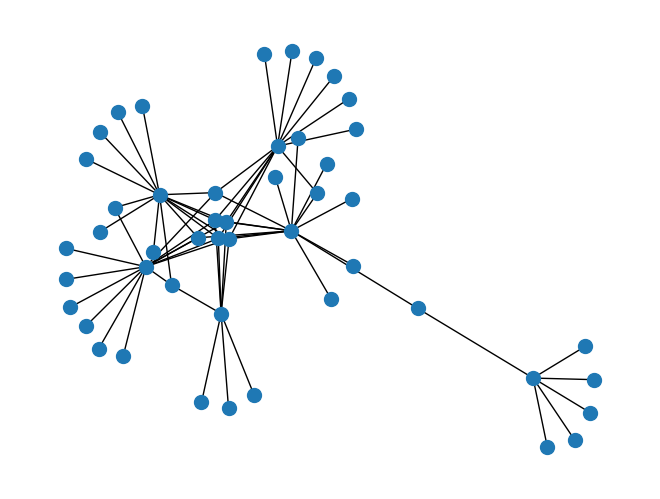

In [7]:
graph_structure = ('client', 'id.orig_h', 'service')
G = nx.Graph()
for index, row in train_df.iterrows():
    user_node = row[graph_structure[0]]
    ip_node = row[graph_structure[1]]
    service_node = row[graph_structure[2]]
    G.add_nodes_from([ip_node, service_node, user_node])
    G.add_edge(ip_node, user_node)
    G.add_edge(ip_node, service_node)
# add initial user mappings
new_nodes = [
    ('10.99.99.160', 
     ['HOST/SUPERSECRETXP.G.LAB']
     ), 
    ('10.99.99.29', 
     ['RPCSS/RND-WIN10-1', 'RESTRICTEDKRBHOST/RND-WIN10-1', 'RPCSS/RND-WIN10-1.G.LAB']
     ), 
    ('10.99.99.30', 
     ['GC/CORP-DC.G.LAB/G.LAB', 'PROTECTEDSTORAGE/CORP-DC.G.LAB', 'RPCSS/HR-WIN7-2.G.LAB', 'RPCSS/HR-WIN7-2']
     ), 
    ('10.99.99.27', 
     ['RESTRICTEDKRBHOST/RND-WIN10-2', 'RPCSS/RND-WIN10-2.G.LAB', 'RPCSS/RND-WIN10-2']
     ), 
    ('10.99.99.152', 
     ['GC/CORP-DC.G.LAB/G.LAB', 'RESTRICTEDKRBHOST/HR-WIN7-1', 'RPCSS/HR-WIN7-1.G.LAB']
     ),
    ('10.99.99.5', 
     ['PROTECTEDSTORAGE/CORP-DC.G.LAB', 'HOST/CORP-DC.G.LAB', 'RPCSS/CORP-DC.G.LAB', 'LOCAL.ADMIN', 'ADMINISTRATOR', 'RESTRICTEDKRBHOST/CORP-DC']
     )
    ]
for node_set in new_nodes:
    src = node_set[0]
    for dest in node_set[1]:
        G.add_edge(src, dest)
        
nx.draw(G, node_size=100)

In [8]:
graph = StellarGraph.from_networkx(G)
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 48, Edges: 68

 Node types:
  default: [48]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [68]
        Weights: all 1 (default)
        Features: none


In [9]:
p = 1.0
q = 1.0
dimensions = 128
num_walks = 20
walk_length = 10
window_size = 2
num_iter = 100
workers = 8

In [10]:
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

# init callback class
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [11]:
rw = BiasedRandomWalk(graph)
walks = rw.run(graph.nodes(), n=num_walks, length=walk_length, p=p, q=q)
print(f"Number of random walks for Graph: {len(walks)}")
model = Word2Vec(
    walks,
    vector_size=dimensions,
    window=window_size,
    min_count=0,
    sg=0,
    hs=0,
    negative=10,
    cbow_mean=1,
    workers=workers,
    epochs=num_iter,
    compute_loss=True,
    callbacks=[callback()]
)
model.get_latest_training_loss()

Number of random walks for Graph: 960
Loss after epoch 0: 13907.1806640625
Loss after epoch 1: 8509.5302734375
Loss after epoch 2: 8473.01171875
Loss after epoch 3: 8536.1015625
Loss after epoch 4: 8191.296875
Loss after epoch 5: 7945.52734375
Loss after epoch 6: 7826.453125
Loss after epoch 7: 7689.5703125
Loss after epoch 8: 7529.25
Loss after epoch 9: 7395.7421875
Loss after epoch 10: 7452.40625
Loss after epoch 11: 7370.4296875
Loss after epoch 12: 7284.9140625
Loss after epoch 13: 7175.0234375
Loss after epoch 14: 7268.0546875
Loss after epoch 15: 7152.5546875
Loss after epoch 16: 7170.34375
Loss after epoch 17: 6999.0625
Loss after epoch 18: 7232.984375
Loss after epoch 19: 7159.671875
Loss after epoch 20: 7263.90625
Loss after epoch 21: 7262.390625
Loss after epoch 22: 7257.15625
Loss after epoch 23: 7150.28125
Loss after epoch 24: 7161.015625
Loss after epoch 25: 7059.171875
Loss after epoch 26: 7041.9375
Loss after epoch 27: 7174.03125
Loss after epoch 28: 7272.5
Loss after ep

730033.375

In [12]:
node_ids = model.wv.index_to_key  # list of node IDs
node_embeddings = (model.wv.vectors) 

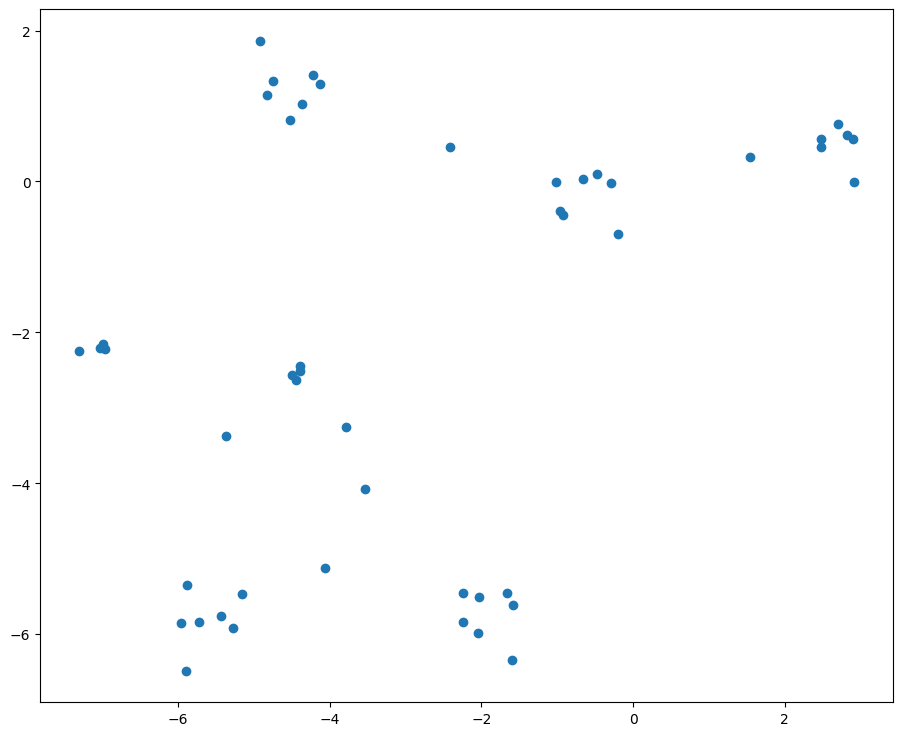

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings_2d = tsne.fit_transform(node_embeddings)
figure = plt.figure(figsize=(11, 9))

ax = figure.add_subplot(111)

ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])

In [14]:
def operator_hadamard(u, v):
    return u * v

In [15]:
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, edges_train, labels_train = edge_splitter_test.train_test_split(
    p=0.99, method="global"
)

** Sampled 67 positive and 67 negative edges. **


In [16]:
training_edges = [operator_hadamard(model.wv[edge[0]], model.wv[edge[1]]) for edge in edges_train]
print(len(training_edges))

134


In [17]:
from sklearn.linear_model import LogisticRegressionCV
clf = LogisticRegressionCV(cv=5, max_iter=1000, random_state=0).fit(training_edges, labels_train)
clf.score(training_edges, labels_train)

1.0

In [18]:
test_G = nx.Graph()
for index, row in test_df.iterrows():
    user_node = row[graph_structure[0]]
    ip_node = row[graph_structure[1]]
    service_node = row[graph_structure[2]]
    test_G.add_nodes_from([ip_node, service_node, user_node])
    test_G.add_edge(user_node, ip_node)
    test_G.add_edge(ip_node, service_node)

In [19]:
test_nodes = set(test_G.nodes)
train_nodes = set(G.nodes)
missing_nodes = test_nodes.difference(train_nodes)
filtered_test_G = test_G.copy()
for index, edge in enumerate(filtered_test_G.edges):
    if edge[0] in missing_nodes or edge[1] in missing_nodes:
        filtered_test_G.remove_edge(*edge)

In [20]:
edge_vectors = []
for index, edge in enumerate(filtered_test_G.edges):
    src = model.wv[edge[0]]
    dest = model.wv[edge[1]]
    src_to_dest = [operator_hadamard(src, dest)]
    prob = clf.predict_proba(src_to_dest)
    if prob[0][1] <= 0.1:
        edge_vectors.append((src_to_dest, 1))
    else:
        edge_vectors.append((src_to_dest, 0))

In [21]:
anomalous_edge_vectors = filter(lambda x: x[1] == 1, edge_vectors)
print(len(list(anomalous_edge_vectors)))

23


In [22]:
tsne = TSNE(n_components=2, random_state=7, perplexity=15)
embeddings = np.array([edge[0][0] for edge in edge_vectors])
embeddings_2d = tsne.fit_transform(embeddings)

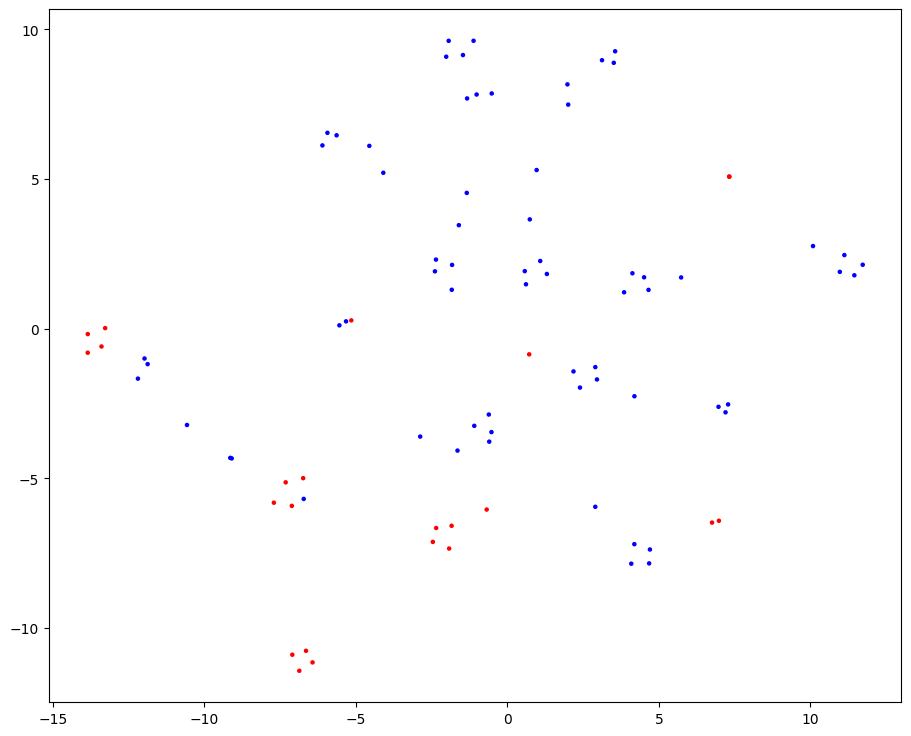

In [23]:
labels = np.array([edge[1] for edge in edge_vectors])
figure = plt.figure(figsize=(11, 9))

ax = figure.add_subplot(111)

ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=5, c=labels, cmap='bwr')

In [24]:
predictions = []
for index, row in test_df.iterrows():
    try:
        client = model.wv[row['client']]
        ip = model.wv[row['id.orig_h']]
        service = model.wv[row['service']]
        client_to_ip = [operator_hadamard(client, ip)]
        ip_to_service = [operator_hadamard(service, ip)]
        prob1 = clf.predict_proba(client_to_ip)
        prob2 = clf.predict_proba(ip_to_service)
        if prob1[0][1] <= 0.1:
            predictions.append(1)
        elif prob2[0][1]<= 0.1:
            predictions.append(1)
        else:
            predictions.append(0)
    except:
        predictions.append(-1)
test_df['predictions'] = predictions

In [25]:
test_df[['client', 'service', 'id.orig_h', 'predictions', 'malicious']]

,client,service,id.orig_h,predictions,malicious
0,RMOLE,LDAP/CORP-DC.G.LAB/G.LAB,10.99.99.27,0,0
1,RMOLE,CIFS/CORP-DC.G.LAB/G.LAB,10.99.99.27,0,0
2,RMOLE,LDAP/CORP-DC.G.LAB,10.99.99.27,0,0
3,RND-WIN10-2$,KRBTGT/G.LAB,10.99.99.27,0,0
4,RND-WIN10-2$,KRBTGT/G.LAB,10.99.99.27,0,0
...,...,...,...,...,...
831,ADMINISTRATOR,RPCSS/CORP-DC.G.LAB,10.99.99.27,1,1
832,ADMINISTRATOR,KRBTGT/G.LAB,10.99.99.27,1,1
833,ADMINISTRATOR,HOST/CORP-DC.G.LAB,10.99.99.27,1,1
834,ADMINISTRATOR,RESTRICTEDKRBHOST/CORP-DC,10.99.99.27,1,1


In [26]:
red_labels = list(test_df.malicious)
labels = list(test_df.predictions)
true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0
for index, label in enumerate(labels):
    if label == 1:
        if red_labels[index] == 1:
            true_positives += 1
        else:
            false_positives += 1
    else:
        if red_labels[index] == 1:
            false_negatives += 1
        else:
            true_negatives += 1
print(f'true postives: {true_positives}')
print(f'true negatives: {true_negatives}')
print(f'false postives: {false_positives}')
print(f'false negatives: {false_negatives}')
print(f'false positive rate: {false_positives/(true_negatives+false_positives)}')
print(f'true positive rate: {true_positives/(true_positives+false_negatives)}')

true postives: 122
true negatives: 696
false postives: 8
false negatives: 10
false positive rate: 0.011363636363636364
true positive rate: 0.9242424242424242


In [27]:
test_df['predictions'].value_counts()

0    706
1    130
Name: predictions, dtype: int64

In [28]:
anomaly_df = test_df[test_df['predictions'] == 1]
missing_df = test_df[test_df['predictions'] == -1]

In [29]:
# def explain_graph(anomaly, train_graph):
#     client_neighbors = [n for n in train_graph.neighbors(anomaly[0])]
#     ip_neighbors = [n for n in train_graph.neighbors(anomaly[1])]
#     service_neighbors = [n for n in train_graph.neighbors(anomaly[2])]
#     print(f'client {anomaly[0]} has {len(client_neighbors)} neighbors')
#     print(f'ip {anomaly[1]} has {len(ip_neighbors)} neighbors')
#     print(f'service {anomaly[2]} has {len(service_neighbors)} neighbors')
#     try:
#         client_ip_path = nx.shortest_path(train_graph, source=anomaly[0], target=anomaly[1])
#         print(f'shorest path from client to ip: {client_ip_path}')
#         ip_service_path = nx.shortest_path(train_graph, source=anomaly[1], target=anomaly[2])
#         print(f'shorest path from ip to service: {ip_service_path}')
#         client_to_service_path = client_ip_path + ip_service_path
#     except:
#         client_to_service_path = []
#         print('---------------------no shortest path---------------------------')
#     color_map = []
#     for node in train_graph.nodes:
#         if node == anomaly[1]:
#             color_map.append('red')
#         elif node in ip_service_path:
#             color_map.append('yellow')
#         elif node in client_ip_path:
#             color_map.append('orange')
#         else:
#             color_map.append('green')
#     nx.draw_spring(train_graph, node_color=color_map, node_size=100)

# def explain_df(anomaly, train_df):
#     client_activity = train_df[train_df['client'] == anomaly[0]]
#     ip_activity = train_df[train_df['id.orig_h'] == anomaly[1]]
#     service_activity = train_df[train_df['service'] == anomaly[2]]
#     display(client_activity)
#     display(ip_activity)
#     display(service_activity)

In [30]:
anomaly_df[['client', 'id.orig_h', 'service', 'ts']]

,client,id.orig_h,service,ts
229,SQUIRREL,10.99.99.160,KRBTGT/G,2019-07-20 12:43:15.955452+00:00
308,JDOE,10.99.99.152,RPCSS/HR-WIN7-2,2019-07-20 15:10:17.312420+00:00
310,JDOE,10.99.99.152,BDUCK,2019-07-20 15:10:17.345530+00:00
364,RMOLE,10.99.99.30,KRBTGT/G,2019-07-20 16:56:24.205290+00:00
365,RMOLE,10.99.99.30,KRBTGT/G,2019-07-20 16:56:24.216751+00:00
...,...,...,...,...
831,ADMINISTRATOR,10.99.99.27,RPCSS/CORP-DC.G.LAB,2019-07-21 15:57:53.695307+00:00
832,ADMINISTRATOR,10.99.99.27,KRBTGT/G.LAB,2019-07-21 15:57:53.704911+00:00
833,ADMINISTRATOR,10.99.99.27,HOST/CORP-DC.G.LAB,2019-07-21 15:57:53.713454+00:00
834,ADMINISTRATOR,10.99.99.27,RESTRICTEDKRBHOST/CORP-DC,2019-07-21 15:57:53.715331+00:00


In [32]:
anomalies = []
for index, row in anomaly_df.iterrows():
    anomaly = [row['client'], row['id.orig_h'], row['service']]
    anomalies.append(anomaly)

# for anomaly in anomalies:
#     explain_graph(anomaly, G)
#     explain_df(anomaly, train_df)
#     break

In [33]:
def explain_graph(anomaly, train_graph):
    
    def filter_node(node):
        return node in filtered_nodes
    
    client_node, ip_node, service_node = anomaly
    client_neighbors = [n for n in train_graph.neighbors(client_node)]
    ip_neighbors = [n for n in train_graph.neighbors(ip_node)]
    service_neighbors = [n for n in train_graph.neighbors(service_node)]
    print(f'client {anomaly[0]} has {len(client_neighbors)} neighbors')
    print(f'ip {anomaly[1]} has {len(ip_neighbors)} neighbors')
    print(f'service {anomaly[2]} has {len(service_neighbors)} neighbors')
    filtered_nodes = set(client_neighbors + ip_neighbors + service_neighbors + anomaly)
    view = nx.subgraph_view(train_graph, filter_node = filter_node)
    ColorScale = plt.get_cmap('RdYlGn')
    subgraph = nx.Graph(view)
    subgraph.add_edge(client_node, ip_node)
    subgraph.add_edge(ip_node, service_node)
    for edge in subgraph.edges:
        src, dest = edge
        edge_embedding = [operator_hadamard(model.wv[src],model.wv[dest])]
        edge_prob = clf.predict_proba(edge_embedding)
        subgraph[src][dest]['prob'] = ColorScale(edge_prob[0][1])
    node_colors = []
    for node in subgraph.nodes:
        if node == client_node:
            node_colors.append('yellow')
        elif node == ip_node:
            node_colors.append('orange')
        elif node == service_node:
            node_colors.append('red')
        else:
            node_colors.append('#1f77b4')
    edge_colors = [x[2] for x in subgraph.edges.data('prob')]
    nx.draw(subgraph, edge_color=edge_colors, node_color=node_colors, with_labels=True)


#     print(f'client {anomaly[0]} has {len(client_neighbors)} neighbors')
#     print(f'ip {anomaly[1]} has {len(ip_neighbors)} neighbors')
#     print(f'service {anomaly[2]} has {len(service_neighbors)} neighbors')
#     try:
#         client_ip_path = nx.shortest_path(train_graph, source=anomaly[0], target=anomaly[1])
#         print(f'shorest path from client to ip: {client_ip_path}')
#         ip_service_path = nx.shortest_path(train_graph, source=anomaly[1], target=anomaly[2])
#         print(f'shorest path from ip to service: {ip_service_path}')
#         client_to_service_path = client_ip_path + ip_service_path
#     except:
#         client_to_service_path = []
#         print('---------------------no shortest path---------------------------')
#     color_map = []
#     for node in train_graph.nodes:
#         if node == anomaly[1]:
#             color_map.append('red')
#         elif node in ip_service_path:
#             color_map.append('yellow')
#         elif node in client_ip_path:
#             color_map.append('orange')
#         else:
#             color_map.append('green')
#     nx.draw_spring(train_graph, node_color=color_map, node_size=100)

client RMOLE has 1 neighbors
ip 10.99.99.30 has 14 neighbors
service HOST/RND-WIN10-2.G.LAB has 1 neighbors


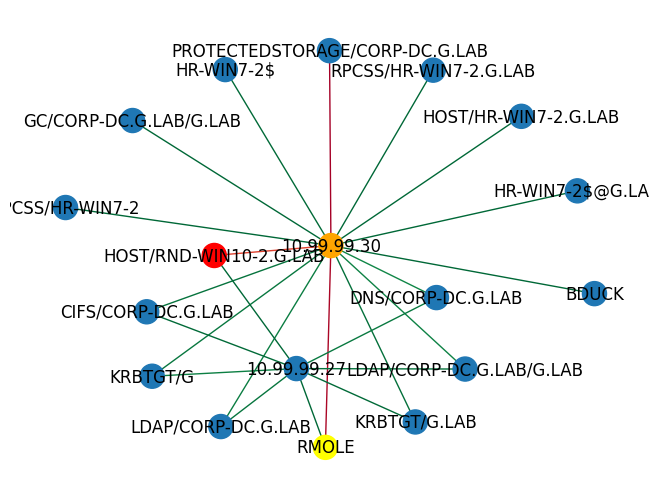

In [41]:
explain_graph(anomalies[75], G)